 """ Compares dimensionality of representations by comparing variance explained by PC1 vs. PC2 for each regime"""

In [6]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

from cryptic_rnn import *

In [2]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
hidden_size = 20

# Sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)
print('trainseqs_bp ',trainseqs_bp)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
valset_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

print('testseqs ', testseqs )

cue_dict  {'A': 10, 'B': 5, 'C': 2, 'D': 13}
primitives  [[('+', 'A'), '=', 10], [('+', 'B'), '=', 5], [('+', 'C'), '=', 2], [('+', 'D'), '=', 13]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'C'), ('+', 'A'), '=', 12]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'C'), ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 12], ['B', ('+', 'D'), '=', 18]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'C'), ('+', 'A'), '=', 12], [('+', 'A'), '=', 10], [('+', 'B'), '=', 5], [('+', 'C'), '=', 2], [('+', 'D'), '=', 13]]
trainseqs_bp  [[('+', 'A'), ('+', 'B'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 7], [('+', 'C'), ('+', 'A'), '=', 12], ['A', ('+', 'C'), '=', 12], ['B', ('+', 'D'), '=', 18], [('+', 'A'), '=', 10], [('+', 'B'), '=', 5], [('+', 'C'), '=', 2], [('+', 'D'), '=', 13]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 20], [('+', 'A'), ('+', 'C'), '=', 12], [('+', '

In [3]:
## read data 
save_dir = '../results/addition_trigrams_3inputs_bp'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)
    
full_rdmats = calculate_RDMs(res1, testseqs_all, subset = 'all')
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

no. 100% trained RNNs:  600


# PCA variance explained

Step = 2

For each regime\
   For each RNN\
       fit PCA\
       variance explained by PC1\
       variance explained by pc2
       
scatter/density plot of density for each model in each regime for PC1
       

In [64]:
t = 2

regimes = [dms_p[t],dms_b[t]]
pc1_vals = []
pc2_vals = []
pc3_vals = []
for regime in regimes:
    pc1 = []
    pc2 = []
    pc3 = []
    for mat in regime:
        pca = PCA(n_components=3)
        pca_fit = pca.fit_transform(mat)
        pc1.append(pca.explained_variance_ratio_[0])
        pc2.append(pca.explained_variance_ratio_[1])
        pc3.append(pca.explained_variance_ratio_[2])
    pc1_vals.append(pc1)
    pc2_vals.append(pc2)
    pc3_vals.append(pc3)
    
    

In [65]:
np.array(pc2_vals).shape

(2, 600)

In [66]:
np.array(pc1_vals).mean(axis=1)

array([0.75815065, 0.81588854])

In [67]:
np.array(pc2_vals).mean(axis=1)

array([0.20058713, 0.16350911])

In [68]:
np.array(pc3_vals).mean(axis=1)

array([0.02211623, 0.01095155])

In [69]:
scipy.stats.wilcoxon(np.array(pc1_vals)[0,:], np.array(pc1_vals)[1,:])

WilcoxonResult(statistic=53766.0, pvalue=1.079957461491548e-17)

# Plot

In [73]:
N = len(dms_p[0])

pc1_all = [pc for sublist in pc1_vals for pc in sublist]
pc2_all = [pc for sublist in pc2_vals for pc in sublist]
pc3_all = [pc for sublist in pc3_vals for pc in sublist]

regime_names = (['S_P']*N + ['B_NP']*N )*3
all_PCs = pc1_all + pc2_all + pc3_all
pc_number = [1]*len(pc1_all) + [2]*len(pc2_all) + [3]*len(pc3_all)

pca_df = pd.DataFrame({'Regime': regime_names, 'PC': pc_number,'Variance explained': all_PCs}) 
#xpos = np.repeat([0,1,2], N) + np.random.normal(0, 0.05, N*3)

<AxesSubplot: xlabel='PC', ylabel='Variance explained'>

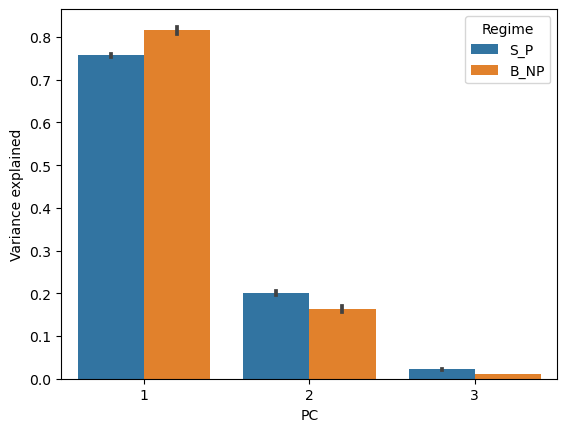

In [75]:
# pca 1
sns.barplot(pca_df, x = 'PC', y = 'Variance explained', hue='Regime' )
# plt.scatter(xpos, pc1_all, alpha=0.3)
# x_p = [0,1]
# y_p = [np.median(pc1_vals[0]), np.median(pc1_vals[1])]
# plt.plot(x_p, y_p, color='black')
# x_bp = [1,2]
# y_bp = [np.median(pc1_vals[1]), np.median(pc1_vals[2])]
# plt.plot(x_bp, y_bp, color='black')

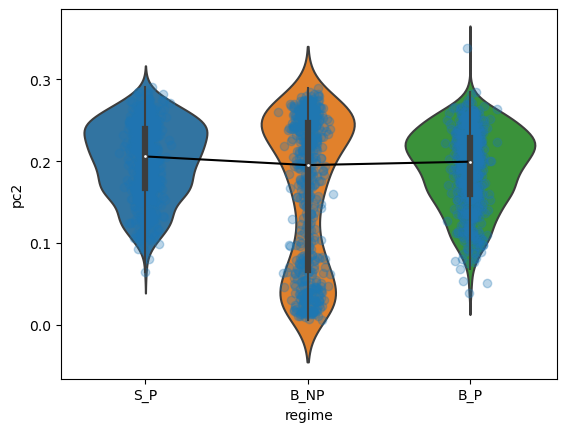

In [63]:
# pca 1
sns.violinplot(pca_df, x = 'regime', y = 'pc2')
plt.scatter(xpos, pc2_all, alpha=0.3)
x_p = [0,1]
y_p = [np.median(pc2_vals[0]), np.median(pc2_vals[1])]
plt.plot(x_p, y_p, color='black')
x_bp = [1,2]
y_bp = [np.median(pc2_vals[1]), np.median(pc2_vals[2])]
plt.plot(x_bp, y_bp, color='black')

# Colors

In [90]:
cpal = sns.color_palette("viridis")
ca, cb, cc, cd = cpal[-1], cpal[-3], cpal[1],  cpal[0]
abcd_pal = [ca, cb, cc, cd]

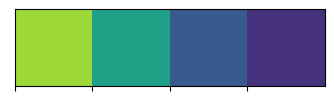

In [91]:
sns.palplot(abcd_pal)
plt.show()

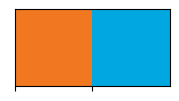

In [94]:
colors = ['#F17720', '#00A7E1']
sns.palplot(colors)
plt.show()

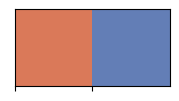

In [95]:

colors = ['#da7959', '#637eb6']
sns.palplot(colors)
plt.show()

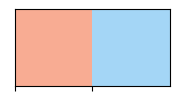

In [98]:
colors = ['#f8ac93', '#a4d6f6']
sns.palplot(colors)
plt.show()